# Chapter 1: Introduction

This notebook explores a simple temporal-difference (TD) learning algorithm on the game tic-tac-toe (and some variations).

In [1]:
from collections import defaultdict
import random
from typing import *
from enum import Enum

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import gym
from gym import spaces

In [2]:
def rotate(sliceable, n):
    '''Rotates any sliceable to the left by n.'''
    n %= len(sliceable)
    return sliceable[n:] + sliceable[:n]

for n in range(5):
    print(rotate((1, 2, 3, 4), n))

def replace(tup, row, col, value):
    '''Updating multi-dimension tuples in python is kind of annoying...'''
    new_tup = list(list(row) for row in tup)
    new_tup[row][col] = value
    return tuple(tuple(row) for row in new_tup)

foo = ((1, 2), (3, 4))
replace(foo, 0, 0, -1)

(1, 2, 3, 4)
(2, 3, 4, 1)
(3, 4, 1, 2)
(4, 1, 2, 3)
(1, 2, 3, 4)


((-1, 2), (3, 4))

In [3]:
class BoardState(NamedTuple):
    '''An immutable (and hashable) state object for tic-tac-toe-like games.'''
    board: Tuple[Tuple[int, ...], ...]
    player_order: Tuple[int, ...]
        
    @classmethod
    def initial(cls, size, players):
        board = tuple([(0,) * size] * size)
        player_order = tuple(range(1, players+1))
        return cls(board, player_order)
    
    @property
    def size(self):
        return len(self.board)
                    
    @property
    def last_player(self):
        return self.player_order[-1]
    
    @property
    def next_player(self):
        return self.player_order[0]
        
    def __getitem__(self, key):
        if type(key) == tuple:
            row, col = key
            return self.board[row][col]
        else:
            return tuple.__getitem__(self, key)
        
    @property
    def valid_actions(self):
        for r in range(self.size):
            for c in range(self.size):
                if self[r, c] == 0:
                    yield (r, c)
    
    @property
    def random_action(self):
        actions = list(self.valid_actions)
        return random.choice(actions)
    
    @property
    def is_full(self):
        return not any(self.valid_actions)
    
    @property
    def is_won(self):
        player = self.last_player
        
        for r in range(self.size):
            if all([self[r, c] == player for c in range(self.size)]):
                return True

        for c in range(self.size):
            if all([self[r, c] == player for r in range(self.size)]):
                return True

        return all([self[i, i] == player for i in range(self.size)]) or \
            all([self[i, self.size - i - 1] == player for i in range(self.size)])
    
    @property
    def is_tied(self):
        return self.is_full and not self.is_won
    
    @property
    def is_done(self):
        return self.is_full or self.is_won
    
    def __call__(self, action):
        new_player_order = rotate(self.player_order, 1)
        
        row, col = action
        proposed = self[row, col]
        if proposed != 0:
            return self._replace(player_order=new_player_order)
        
        new_board = replace(self.board, row, col, self.next_player)
        return BoardState(new_board, new_player_order)
    
state = BoardState.initial(3, 2)
while not state.is_done:
    state = state(state.random_action)
    
print(state)

BoardState(board=((1, 0, 2), (2, 2, 1), (2, 1, 1)), player_order=(1, 2))


In [5]:
class Reward(Enum):
    WIN = 1
    TIE = 0
    LOSS = -1

class Observation(NamedTuple):
    state: BoardState
    reward: Reward
    done: bool
    info: Any

In [6]:
class TicTacToeEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, size=3, markers='XO'):
        self.size = size
        self.markers = markers
        self.n_players = len(markers)
        
        self.reward_range = (Reward.LOSS, Reward.WIN)
        
        # An action is simply specifying which space on the board to play next.
        self.action_space = spaces.Tuple([spaces.Discrete(size)] * 2)
        
        # The observation space is a tuple with two elements, the board and the player order.
        # The board is a tuple, one element for each space on the board, which can contain
        # 0 for empty or {player number}.
        size_space = spaces.Discrete(size)
        board_space = spaces.Tuple([spaces.Discrete(self.n_players + 1)] * (size ** 2))
        next_player_space = spaces.Tuple([spaces.Discrete(self.n_players)] * self.n_players)
        self.observation_space = spaces.Tuple([size_space, board_space, next_player_space])
        
        self.reset()
        
    def reset(self):
        self.state = BoardState.initial(self.size, self.n_players)
        return self.state
            
    def step(self, action):
        self.state = self.state(action)
        
        if self.state.is_won:
            return Observation(self.state, 1, True, {})
        elif self.state.is_tied:
            return Observation(self.state, 0, True, {})
        else:
            return Observation(self.state, None, False, {})
        
    def render_player(self, player):
        return ' ' if player < 1 else self.markers[player-1]
                
    def render_board(self, state):
        size = state.size
        for row in range(size):
            if row > 0:
                print('─' * ((size*2)-1))
            
            for col in range(size):
                if col > 0:
                      print("|", end="")
                print(self.render_player(state[row, col]), end="")
            print()
    
    def render_state(self, state):
        self.render_board(state)
        print("Last Play: " + self.render_player(state.last_player))

    def render(self, mode='human'):
        self.render_state(self.state)

ttt = TicTacToeEnv()
state = ttt.reset()
done = False
while not done:
    state, reward, done, info = ttt.step(ttt.state.random_action)
ttt.render()
print('Reward: {}'.format(reward))

X|X|O
─────
X|O|O
─────
O|X| 
Last Play: O
Reward: 1


In [7]:
class Agent(object):
    def reset(self):
        pass
    
    def act(self, state):
        raise NotImplemented
        
    def reward(self, reward):
        pass

class RandomAgent(Agent):
    def __init__(self, name):
        self.name = name
        self.reset()
    
    def reset(self):
        self.score = 0
    
    def act(self, state):
        return state.random_action
    
    def reward(self, reward):
        self.score += reward
                            
rando = RandomAgent("Rando")
state = ttt.reset()
action = rando.act(state)
print(action)
ttt.step(action)
ttt.render()

(2, 0)
 | | 
─────
 | | 
─────
X| | 
Last Play: X


X|X|O
─────
O|O|X
─────
X|O|X
Tied!



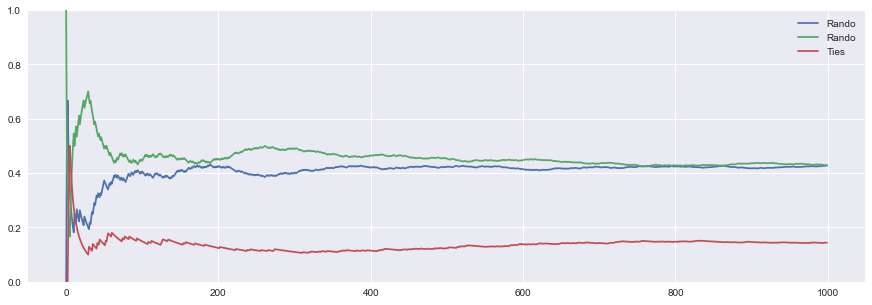

In [142]:
class Matchup(NamedTuple):
    env: TicTacToeEnv
    agents: List[Agent]
        
    @classmethod
    def create(cls, env, *agents):
        if env.n_players != len(agents):
            raise ValueError('Please specify one agent for each player.')
        
        return cls(env, list(agents))
        
    def run(self, callback=None, reward=True):
        # Randomly assign an agent to a player position.
        players = list(range(1, self.env.n_players+1))
        random.shuffle(players)
        player_assignment = {p: a for a, p in enumerate(players)}
                    
        state = self.env.reset()
        done = False
        while not done:
            agent = self.agents[player_assignment[state.next_player]]
            action = agent.act(state)
            state, reward, done, info = self.env.step(action)
            if callback is not None:
                callback(state)
        
        game_result = GameResult(self, player_assignment, state, reward)
        if reward:
            for agent_id, reward in enumerate(game_result.rewards):
                self.agents[agent_id].reward(reward)
            
        return game_result
    
    def run_many(self, games, reward=True):
        results = [self.run(reward=reward) for game in range(games)]
        return GameSeries(self, results)

class GameResult(NamedTuple):
    matchup: Matchup
    player_assignment: Dict[int, int]
    end_state: BoardState
    reward: Reward
        
    @property
    def rewards(self):
        last_agent_id = self.player_assignment[self.end_state.last_player]
        def score(agent_id):
            return self.reward if agent_id == last_agent_id else -self.reward
        return [score(a) for a, agent in enumerate(self.matchup.agents)]
                
    def render(self):
        env = self.matchup.env
        env.render_board(self.end_state)
        
        last_player = self.end_state.last_player
        last_agent = self.player_assignment[last_player]
        
        marker = env.render_player(self.end_state.last_player)
        agent = self.matchup.agents[last_agent]
        
        if self.end_state.is_tied:
            print('Tied!')
        elif self.end_state.is_won:
            print('Player {} ({}) won!'.format(marker, agent.name))
        else:
            print('Player {} ({}) lost!'.format(marker, agent.name))
            
class GameSeries(object):
    def __init__(self, matchup, results):
        self.matchup = matchup
        self.results = results
        
    def plot(self):
        '''Plots win-rate over a series of games.'''
        foo = [result.rewards for result in self.results]
        bar = [result.reward for result in self.results]
        
        shape = (len(self.results), len(self.matchup.agents))
        wins = np.zeros(shape=shape)
        for i, result in enumerate(self.results):
            for a, reward in enumerate(result.rewards):
                wins[i, a] = max(0, reward)
        
        ties = np.array([1 if result.reward == 0 else 0 for result in self.results]).reshape(-1, 1)
        data = np.concatenate([wins, ties], axis=1)
        
        columns = [agent.name for agent in self.matchup.agents] + ['Ties']
        win_rate = pd.DataFrame(data, columns=columns).rolling(1000, min_periods=1).mean()
        win_rate.plot(figsize=(15, 5), ylim=(0,1))
                                    
rando_vs_rando = Matchup.create(ttt, rando, rando)
rando_vs_rando.run().render()
print()
rando_vs_rando.run_many(1000).plot()

In [143]:
class LinearUpdate(object):
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        
    def __call__(self, v0, v1):
        return v0 + self.alpha * (v1 - v0);
        
class EpsilonGreedy(object):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        
    def __call__(self, action_scores):
        explore = np.random.random() < self.epsilon
        actions = list(action_scores.keys())

        # There's a good reason to shuffle the valid actions.
        # When the state space is not well visited, most states will be equally weighted.
        # If we didn't shuffle, the sort below this would be deterministic and a 100% greedy agent
        # would always learn the same strategy. (which, for this particular impl just
        # happens to be the optimal one!)
        random.shuffle(actions)

        if not explore:
            actions = sorted(actions, key=lambda action: action_scores[action])

        return explore, actions[0]
    
class TDAgent(object):
    def __init__(self, choose_action, update_value, name='TD'):
        '''A simple temporal-difference learning agent.
        This particular agent has a prior knowledge of the game being played (TTT), in that
        it knows which moves are valid.
        '''
        self.choose_action = choose_action
        self.update_value = update_value
        self.name = name
        self.reset()
        
    def reset(self):
        self.values = defaultdict(lambda: 0.5)
        self.prev_state = None
    
    def act(self, state):
        valid_actions = list(state.valid_actions)
        action_scores = {action: self.values[state(action)] for action in valid_actions}
        
        explored, action = self.choose_action(action_scores)
        if not explored:
            prev_value = self.values[self.prev_state]
            curr_value = self.values[state]
            self.values[self.prev_state] = self.update_value(prev_value, curr_value)

        self.prev_state = state

        return action
    
    def reward(self, reward):
        self.values[self.prev_state] = reward
        
todd = TDAgent(EpsilonGreedy(), LinearUpdate(), 'Todd')

In [144]:
def train(p1, p2, n=25000):
    p1.reset()
    p2.reset()
    return Matchup.create(ttt, p1, p2).run_many(n)
    
def evaluate(p1, p2, n=1000):
    return Matchup.create(ttt, p1, p2).run_many(n)
    
def train_evaluate(p1, p2):
    train(p1, p2).plot()
    evaluate(p1, p2).plot()

## Random vs TDAgent

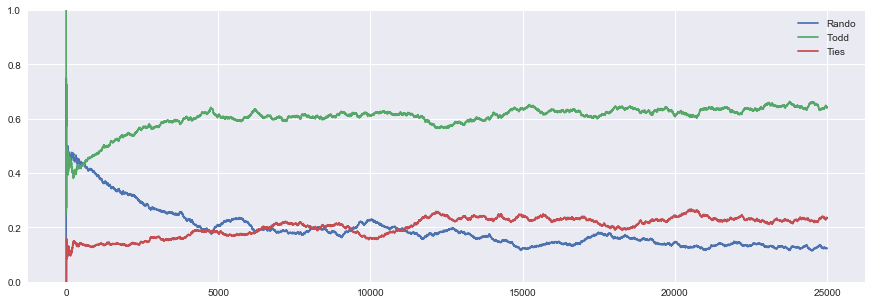

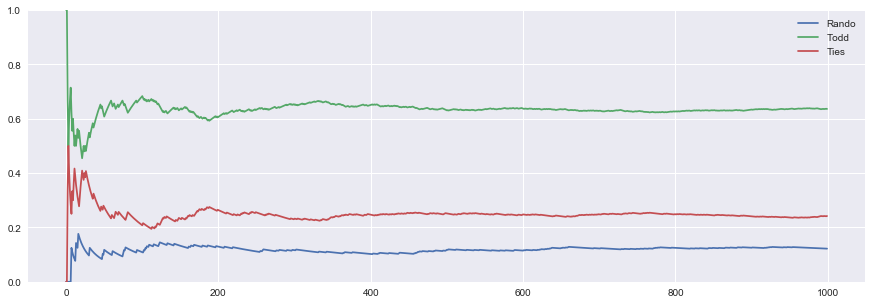

In [145]:
train_evaluate(rando, todd)

## 1.1 Self-Play

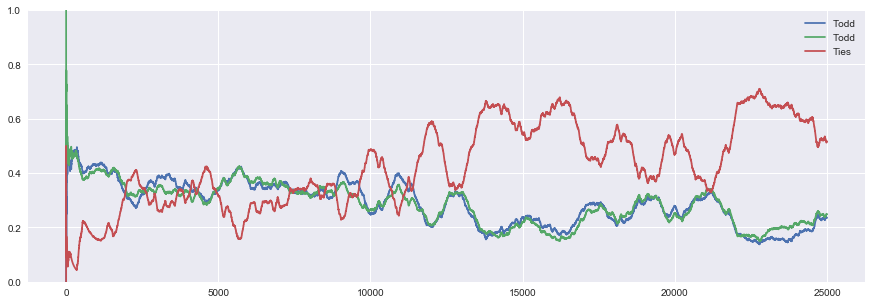

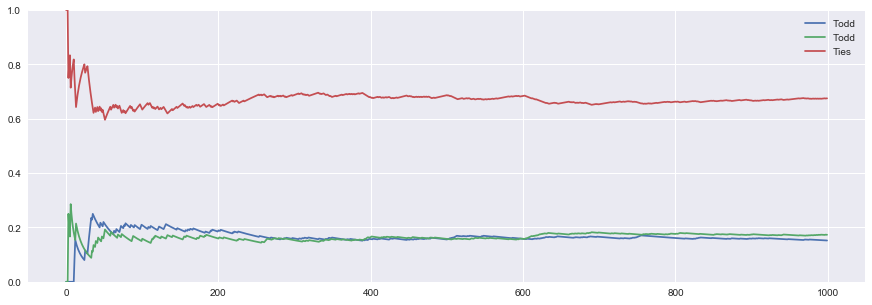

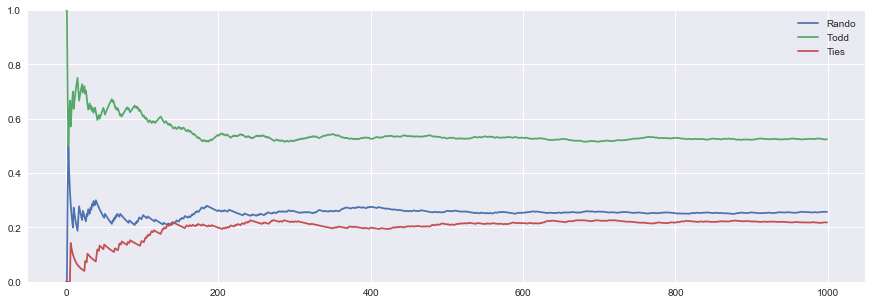

In [150]:
train_evaluate(todd, todd)
evaluate(rando, todd).plot()

## 1.2: Symmetries

## 1.3: Greedy Play

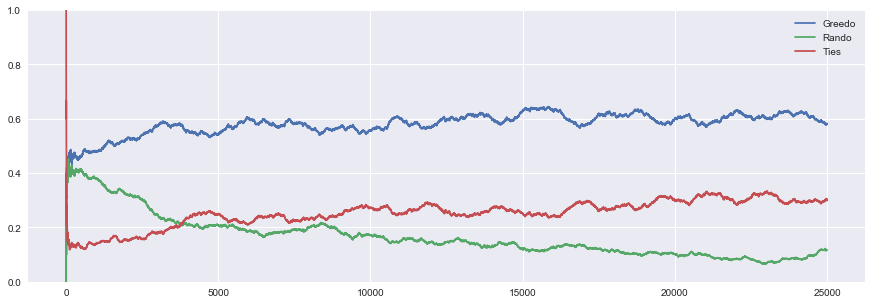

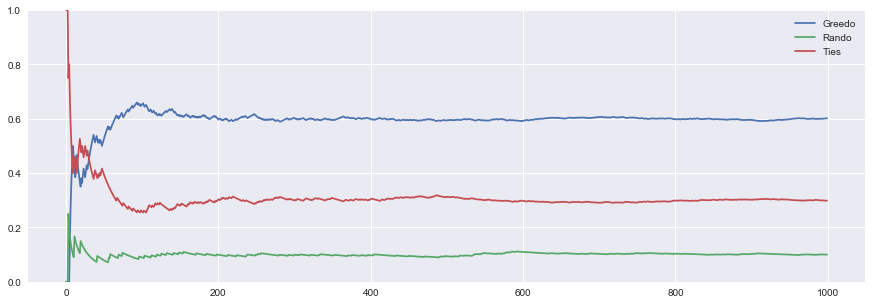

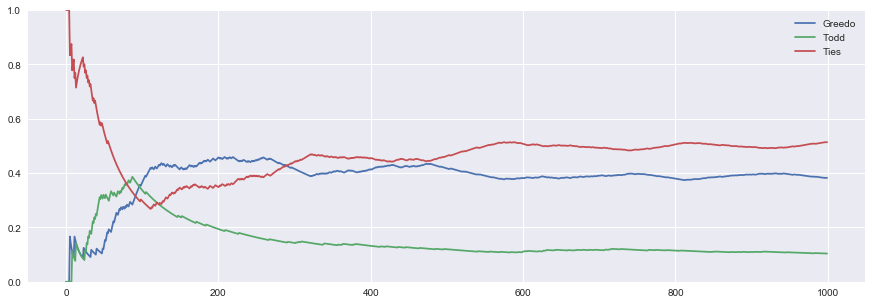

In [151]:
greedo = TDAgent(EpsilonGreedy(0.), LinearUpdate(), 'Greedo')
train_evaluate(greedo, rando)
evaluate(greedo, todd).plot()